# Deep Convolutional GANs

In this notebook, you'll build a GAN using convolutional layers in the generator and discriminator. This is called a Deep Convolutional GAN, or DCGAN for short. The DCGAN architecture was first explored last year and has seen impressive results in generating new images, you can read the [original paper here](https://arxiv.org/pdf/1511.06434.pdf).

You'll be training DCGAN on the [Street View House Numbers](http://ufldl.stanford.edu/housenumbers/) (SVHN) dataset. These are color images of house numbers collected from Google street view. SVHN images are in color and much more variable than MNIST. 

![SVHN Examples](assets/SVHN_examples.png)

So, we'll need a deeper and more powerful network. This is accomplished through using convolutional layers in the discriminator and generator. It's also necessary to use batch normalization to get the convolutional networks to train. The only real changes compared to what [you saw previously](https://github.com/udacity/deep-learning/tree/master/gan_mnist) are in the generator and discriminator, otherwise the rest of the implementation is the same.

In [1]:
%matplotlib inline

import pickle as pkl

import matplotlib.pyplot as plt
import numpy as np
from scipy.io import loadmat
import tensorflow as tf

In [2]:
!mkdir data

mkdir: cannot create directory ‘data’: File exists


## Getting the data

Here you can download the SVHN dataset. Run the cell above and it'll download to your machine.

In [3]:
from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm

data_dir = 'data/'

if not isdir(data_dir):
    raise Exception("Data directory doesn't exist!")

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not isfile(data_dir + "train_32x32.mat"):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='SVHN Training Set') as pbar:
        urlretrieve(
            'http://ufldl.stanford.edu/housenumbers/train_32x32.mat',
            data_dir + 'train_32x32.mat',
            pbar.hook)

if not isfile(data_dir + "test_32x32.mat"):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='SVHN Testing Set') as pbar:
        urlretrieve(
            'http://ufldl.stanford.edu/housenumbers/test_32x32.mat',
            data_dir + 'test_32x32.mat',
            pbar.hook)

These SVHN files are `.mat` files typically used with Matlab. However, we can load them in with `scipy.io.loadmat` which we imported above.

In [4]:
trainset = loadmat(data_dir + 'train_32x32.mat')
testset = loadmat(data_dir + 'test_32x32.mat')

Here I'm showing a small sample of the images. Each of these is 32x32 with 3 color channels (RGB). These are the real images we'll pass to the discriminator and what the generator will eventually fake.

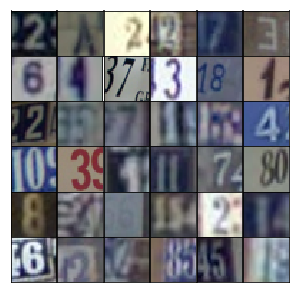

In [5]:
idx = np.random.randint(0, trainset['X'].shape[3], size=36)
fig, axes = plt.subplots(6, 6, sharex=True, sharey=True, figsize=(5,5),)
for ii, ax in zip(idx, axes.flatten()):
    ax.imshow(trainset['X'][:,:,:,ii], aspect='equal')
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
plt.subplots_adjust(wspace=0, hspace=0)

Here we need to do a bit of preprocessing and getting the images into a form where we can pass batches to the network. 
First off, we need to rescale the images to a range of -1 to 1, since the output of our generator is also in that range. 
We also have a set of test and validation images which could be used if we're trying to identify the numbers in the images.

In [6]:
# Scale works the same as Tanh
def scale(x, feature_range=(-1, 1)):
    # scale to (0, 1)
    x = ((x - x.min())/(255 - x.min()))
    
    # scale to feature_range
    min, max = feature_range
    x = x * (max - min) + min
    return x

In [7]:
class Dataset:
    def __init__(self, train, test, val_frac=0.5, shuffle=False, scale_func=None):
        split_idx = int(len(test['y'])*(1 - val_frac))
        self.test_x, self.valid_x = test['X'][:,:,:,:split_idx], test['X'][:,:,:,split_idx:]
        self.test_y, self.valid_y = test['y'][:split_idx], test['y'][split_idx:]
        self.train_x, self.train_y = train['X'], train['y']
        
        self.train_x = np.rollaxis(self.train_x, 3)
        self.valid_x = np.rollaxis(self.valid_x, 3)
        self.test_x = np.rollaxis(self.test_x, 3)
        
        if scale_func is None:
            self.scaler = scale
        else:
            self.scaler = scale_func
        self.shuffle = shuffle
        
    def batches(self, batch_size):
        if self.shuffle:
            idx = np.arange(len(self.train_x))
            np.random.shuffle(idx)
            self.train_x = self.train_x[idx]
            self.train_y = self.train_y[idx]
        
        n_batches = len(self.train_y)//batch_size
        for ii in range(0, len(self.train_y), batch_size):
            x = self.train_x[ii:ii+batch_size]
            y = self.train_y[ii:ii+batch_size]
            
            yield self.scaler(x), y
            #yield x, y

## Network Inputs

Here, just creating some placeholders like normal.

In [8]:
def model_inputs(input_dim):
    # Input data to the modal
    inputs = tf.placeholder(tf.float32, (None, *input_dim), name=None)
    
    # Indices/output/target/classes data to the model
    indices = tf.placeholder(tf.int32, (None), name=None)    
    
    return inputs, indices

## Generator

Here you'll build the generator network. The input will be our noise vector `z` as before. Also as before, the output will be a $tanh$ output, but this time with size 32x32 which is the size of our SVHN images.

What's new here is we'll use convolutional layers to create our new images. The first layer is a fully connected layer which is reshaped into a deep and narrow layer, something like 4x4x1024 as in the original DCGAN paper. Then we use batch normalization and a leaky ReLU activation. Next is a transposed convolution where typically you'd halve the depth and double the width and height of the previous layer. Again, we use batch normalization and leaky ReLU. For each of these layers, the general scheme is convolution > batch norm > leaky ReLU.

You keep stacking layers up like this until you get the final transposed convolution layer with shape 32x32x3. Below is the archicture used in the original DCGAN paper:

![DCGAN Generator](assets/dcgan.png)

Note that the final layer here is 64x64x3, while for our SVHN dataset, we only want it to be 32x32x3.

In [9]:
# tf.layers.conv2d(
#     inputs, ----------
#     filters, -------------
#     kernel_size, ------------
#     strides=(1, 1), ---------------
#     padding='valid', ------------
#     data_format='channels_last', -------------> NHWC and not NCHW
#     dilation_rate=(1, 1), -------------------
#     activation=None,
#     use_bias=True, ------------------
#     kernel_initializer=None,
#     bias_initializer=tf.zeros_initializer(), ------------------
#     kernel_regularizer=None,
#     bias_regularizer=None,
#     activity_regularizer=None,
#     kernel_constraint=None,
#     bias_constraint=None,
#     trainable=True, ---------------------
#     name=None,
#     reuse=None
# )

In [10]:
# Qfunction or qfunction, q/Q is quality and this is used as a classifier or q-learning or q-network
def qfunction(inputs, output_dim, reuse=False, alpha=0.1, training=True):
    with tf.variable_scope('qfunction', reuse=reuse):
        # Input layer is 32x32x3
        h1 = tf.layers.conv2d(inputs=inputs, filters=64, kernel_size=5, strides=2, padding='same')
        bn1 = tf.layers.batch_normalization(h1, training=training)
        nl1 = tf.maximum(alpha * bn1, bn1)
        # 16x16x64
        
        h2 = tf.layers.conv2d(inputs=nl1, filters=128, kernel_size=5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(h2, training=training)
        nl2 = tf.maximum(alpha * bn2, bn2)
        # 8x8x128
        
        h3 = tf.layers.conv2d(inputs=nl2, filters=256, kernel_size=5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(h3, training=training)
        nl3 = tf.maximum(alpha * bn3, bn3)
        # 4x4x256

        # Flatten it to the number of classes 
        # Let's imagine (4*4*512) is the number of classes.
        nl3_vec = tf.reshape(nl3, (-1, 4*4*256))
        #logits = tf.layers.dense(nl3_vec, 4*4*512)
        logits = tf.layers.dense(nl3_vec, output_dim) # this is for the classification task
        predictions = tf.nn.softmax(logits)
        # 4x4x512 now
        
        return logits, predictions

In [11]:
def generator(inputs, output_dim, reuse=False, alpha=0.1, training=True):
    with tf.variable_scope('generator', reuse=reuse):
        # Reshape it to start the convolutional stack
        h1 = tf.layers.dense(inputs, 4*4*512)
        bn1 = tf.layers.batch_normalization(h1, training=training)
        nl1 = tf.maximum(alpha * bn1, bn1)
        nl1_mat = tf.reshape(nl1, (-1, 4, 4, 512))
        # 4x4x512 now
        
        h2 = tf.layers.conv2d_transpose(inputs=nl1_mat, filters=256, kernel_size=5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(h2, training=training)
        nl2 = tf.maximum(alpha * bn2, bn2)
        # 8x8x256 now
        
        h3 = tf.layers.conv2d_transpose(inputs=nl2, filters=128, kernel_size=5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(h3, training=training)
        nl3 = tf.maximum(alpha * bn3, bn3)
        # 16x16x128 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(inputs=nl3, filters=output_dim, kernel_size=5, strides=2, padding='same')        
        predictions = tf.tanh(logits) # inputs data is scaled!
        # 32x32x3 now

        # generated input or input fake
        return predictions

## Discriminator

Here you'll build the discriminator. This is basically just a convolutional classifier like you've build before. The input to the discriminator are 32x32x3 tensors/images. You'll want a few convolutional layers, then a fully connected layer for the output. As before, we want a sigmoid output, and you'll need to return the logits as well. For the depths of the convolutional layers I suggest starting with 16, 32, 64 filters in the first layer, then double the depth as you add layers. Note that in the DCGAN paper, they did all the downsampling using only strided convolutional layers with no maxpool layers.

You'll also want to use batch normalization with `tf.layers.batch_normalization` on each layer except the first convolutional and output layers. Again, each layer should look something like convolution > batch norm > leaky ReLU. 

Note: in this project, your batch normalization layers will always use batch statistics. (That is, always set `training` to `True`.) That's because we are only interested in using the discriminator to help train the generator. However, if you wanted to use the discriminator for inference later, then you would need to set the `training` parameter appropriately.

In [12]:
def discriminator(inputs, reuse=False, alpha=0.1, training=True):
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 32x32x3
        h1 = tf.layers.conv2d(inputs=inputs, filters=64, kernel_size=5, strides=2, padding='same')
        bn1 = tf.layers.batch_normalization(h1, training=training)
        nl1 = tf.maximum(alpha * bn1, bn1)
        # 16x16x64
        
        h2 = tf.layers.conv2d(inputs=nl1, filters=128, kernel_size=5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(h2, training=training)
        nl2 = tf.maximum(alpha * bn2, bn2)
        # 8x8x128
        
        h3 = tf.layers.conv2d(inputs=nl2, filters=256, kernel_size=5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(h3, training=training)
        nl3 = tf.maximum(alpha * bn3, bn3)
        # 4x4x256

        # Flatten it
        nl3_vec = tf.reshape(nl3, (-1, 4*4*256))
        logits = tf.layers.dense(nl3_vec, 1)
        #predictions = tf.sigmoid(logits)
        
        return logits

## Model Loss

Calculating the loss like before, nothing new here.

In [33]:
# This is to determin the number of classes
trainset['y'].max(), trainset['y'].min()

(10, 1)

In [36]:
def model_loss(inputs_real, input_dim, indices_real, indices_dim):
    """
    Get the loss for the discriminator and generator
    :param inputs_real: Images from the real dataset
    :param input_dim: Input image dimensions
    :param indices_real: Target/output class/label numbers
    :param indices_dim: Number of output classes or dimensions
    :return: A tuple of (qfunction accuracy, qfunction loss, generator loss, discriminator loss)
    """
    # Generating/reconstructing the fake inputs using real inputs
    q_logits, q_preds = qfunction(inputs=inputs_real, output_dim=indices_dim)
    inputs_fake = generator(inputs=q_preds, output_dim=input_dim)
    
    # Qfunction accuracy
    # Classification accuracy using logits and labels
    #     q_labels = tf.one_hot(depth=indices_dim, indices=indices_real)
    #     q_correct_preds = tf.equal(tf.argmax(input=q_logits, axis=1), tf.argmax(input=q_labels, axis=1))
    #     q_accuracy = tf.reduce_mean(tf.cast(q_correct_preds, tf.float32))

    # Qfunction loss using real and fake inputs
    # Classification error
    q_loss_class = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits_v2(logits=q_logits, 
                                                   labels=tf.one_hot(depth=indices_dim, indices=indices_real)))
    # Reconstruction error
    # q_loss = tf.reduce_mean(tf.losses.mean_squared_error(predictions=input_fake, labels=input_real))
    q_loss_reconst = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=inputs_fake, labels=tf.sigmoid(inputs_real)))
    q_loss = q_loss_reconst + q_loss_class

    # Discriminator logits fake and real for G & D losses
    d_logits_fake = discriminator(inputs=tf.sigmoid(inputs_fake), reuse=False)
    d_logits_real = discriminator(inputs=tf.sigmoid(inputs_real), reuse=True)

    # Generator loss
    g_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.zeros_like(d_logits_real)))
    g_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_logits_fake)))
    g_loss = g_loss_real + g_loss_fake

    # Discriminator loss
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_logits_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_logits_fake)))
    d_loss = d_loss_real + d_loss_fake
    
    return q_loss, g_loss, d_loss

## Optimizers

Not much new here, but notice how the train operations are wrapped in a `with tf.control_dependencies` block so the batch normalization layers can update their population statistics.

In [37]:
def model_opt(q_loss, g_loss, d_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param q_loss: Qfunction loss Tensor
    :param g_loss: Generator loss Tensor
    :param d_loss: Discriminator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    q_vars = [var for var in t_vars if var.name.startswith('qfunction')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        q_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(q_loss, var_list=q_vars)
        g_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
        d_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)

    return q_opt, g_opt, d_opt

## Building the model

Here we can use the functions we defined about to build the model as a class. This will make it easier to move the network around in our code since the nodes and operations in the graph are packaged in one object.

In [39]:
class GAN:
    def __init__(self, input_dim, indices_dim, learning_rate, beta1):
        tf.reset_default_graph()
        
        # Model inputs/data 
        self.inputs_real, self.indices_real = model_inputs(input_dim=input_dim)
        
        # Model losses/logits
        self.q_loss, self.g_loss, self.d_loss = model_loss(inputs_real=self.inputs_real, input_dim=input_dim[2],
                                                           indices_real=self.indices_real, indices_dim=indices_dim)

        # Model update/optimization
        self.q_opt, self.g_opt, self.d_opt = model_opt(q_loss=self.q_loss, 
                                                       g_loss=self.g_loss, 
                                                       d_loss=self.d_loss, 
                                                       learning_rate=learning_rate, beta1=beta1)

Here is a function for displaying generated images.

In [40]:
def view_samples(epoch, samples, nrows, ncols, figsize=(5,5)):
    fig, axes = plt.subplots(figsize=figsize, nrows=nrows, ncols=ncols, 
                             sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        ax.axis('off')
        img = ((img - img.min())*255 / (img.max() - img.min())).astype(np.uint8)
        ax.set_adjustable('box-forced')
        im = ax.imshow(img, aspect='equal')
   
    plt.subplots_adjust(wspace=0, hspace=0)
    return fig, axes

And another function we can use to train our network. Notice when we call `generator` to create the samples to display, we set `training` to `False`. That's so the batch normalization layers will use the population statistics rather than the batch statistics. Also notice that we set the `net.input_real` placeholder when we run the generator's optimizer. The generator doesn't actually use it, but we'd get an error without it because of the `tf.control_dependencies` block we created in `model_opt`. 

In [41]:
def train(model, dataset, epochs, batch_size, print_every=10, show_every=100, figsize=(5,5)):
    saver = tf.train.Saver()
    samples, losses = [], []
    #accs = []
    steps = 0

    # Creating a session for training
    with tf.Session() as sess:
        
        # Initialize the model variable if there is no model available to load/restore
        sess.run(tf.global_variables_initializer())
        
        #         # Restore/load the trained model
        #         #saver.restore(sess, './checkpoints/Auto-DCGAN.ckpt')
        #         saver.restore(sess, tf.train.latest_checkpoint('checkpoints/'))
        
        # Number of epochs for updating the model/s
        for e in range(epochs):
            
            # Training batches
            for inputs_real, indices_real in dataset.batches(batch_size):
                steps += 1

                # Run optimizers
                feed_dict={model.inputs_real: inputs_real, model.indices_real: indices_real}
                _ = sess.run(model.q_opt, feed_dict)
                _ = sess.run(model.g_opt, feed_dict)
                _ = sess.run(model.d_opt, feed_dict)

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    #q_acc = model.q_acc.eval(feed_dict)
                    #q_acc = sess.run(model.q_acc, feed_dict)
                    q_loss = model.q_loss.eval(feed_dict)
                    g_loss = model.g_loss.eval(feed_dict)
                    d_loss = model.d_loss.eval(feed_dict)

                    print("Epoch {}/{}".format(e+1, epochs),
                          #"Qfunction Accuracy:{:.4f}".format(q_acc),
                          "Qfunction Loss:{:.4f}".format(q_loss),
                          "Generator Loss:{:.4f}".format(g_loss),
                          "Discriminator Loss:{:.4f}".format(d_loss))
                    
                    # Save losses to view after training
                    losses.append((q_loss, g_loss, d_loss))
                    #accs.append(q_acc)

                if steps % show_every == 0:
                    _, model_qpreds = qfunction(inputs=model.inputs_real, output_dim=10, reuse=True, training=False)
                    model_glogits = generator(inputs=model_qpreds, output_dim=3, reuse=True, training=False)
                    glogits = sess.run(model_glogits, feed_dict)
                    reconst_inputs = glogits
                    samples.append(reconst_inputs)
                    _ = view_samples(-1, samples, 6, 12, figsize=figsize)
                    plt.show()

        # Save the trained model
        saver.save(sess, './checkpoints/model.ckpt')

    with open('samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    return losses, samples

## Hyperparameters

GANs are very sensitive to hyperparameters. A lot of experimentation goes into finding the best hyperparameters such that the generator and discriminator don't overpower each other. Try out your own hyperparameters or read [the DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf) to see what worked for them.

In [42]:
# ADAM default parameters
# __init__(
#     learning_rate=0.001,
#     beta1=0.9,
#     beta2=0.999,
#     epsilon=1e-08,
#     use_locking=False,
#     name='Adam'
# )

In [43]:
# Dataset for the model
dataset = Dataset(trainset, testset)

In [44]:
dataset.train_y.shape, dataset.train_y.max()

((73257, 1), 10)

In [45]:
image_size = (32,32,3)
num_classes = 10
learning_rate = 0.001
beta1 = 0.5
batch_size = 128
epochs = 10
alpha = 0.1

# Create the network
model = GAN(input_dim=image_size, indices_dim=num_classes, learning_rate=learning_rate, beta1=beta1)

Epoch 1/10 Qfunction Loss:2.5678 Generator Loss:5.2139 Discriminator Loss:1.5580
Epoch 1/10 Qfunction Loss:2.1336 Generator Loss:3.8981 Discriminator Loss:1.0607
Epoch 1/10 Qfunction Loss:1.7938 Generator Loss:2.6720 Discriminator Loss:0.8883
Epoch 1/10 Qfunction Loss:1.5236 Generator Loss:2.6761 Discriminator Loss:0.6650
Epoch 1/10 Qfunction Loss:1.2994 Generator Loss:3.0781 Discriminator Loss:0.6238
Epoch 1/10 Qfunction Loss:1.2662 Generator Loss:2.5683 Discriminator Loss:1.2099
Epoch 1/10 Qfunction Loss:1.1789 Generator Loss:2.9324 Discriminator Loss:1.4462
Epoch 1/10 Qfunction Loss:1.2227 Generator Loss:1.8896 Discriminator Loss:1.2014
Epoch 1/10 Qfunction Loss:1.1351 Generator Loss:2.6051 Discriminator Loss:1.0054
Epoch 1/10 Qfunction Loss:1.3552 Generator Loss:2.2291 Discriminator Loss:0.9124


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/matplotlib/axes/_base.py:1400: MatplotlibDeprecationWarning: The 'box-forced' keyword argument is deprecated since 2.2.
  " since 2.2.", cbook.mplDeprecation)


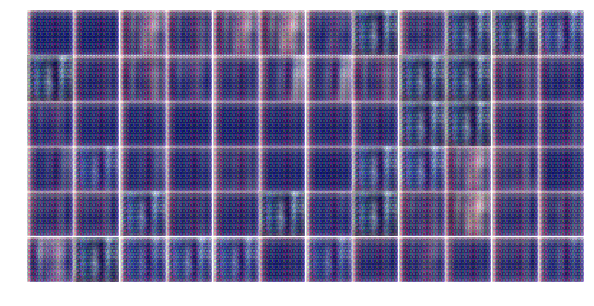

Epoch 1/10 Qfunction Loss:1.2727 Generator Loss:2.2417 Discriminator Loss:0.9143
Epoch 1/10 Qfunction Loss:1.5338 Generator Loss:2.7176 Discriminator Loss:0.7265
Epoch 1/10 Qfunction Loss:1.3845 Generator Loss:2.2105 Discriminator Loss:1.0276


In [ ]:
losses, samples = train(model=model, dataset=dataset, epochs=epochs, batch_size=batch_size, figsize=(10,5))

In [ ]:
fig, ax = plt.subplots()
losses_ = np.array(losses)
losses_norm = (losses_ - losses_.mean(axis=0))/losses_.std(axis=0)
# print(losses_.shape, losses_norm.shape, losses_norm.dtype, losses_norm.dtype)
plt.plot(losses_norm.T[0], label='Generator', alpha=0.5)
plt.plot(losses_norm.T[1], label='Discriminator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

In [ ]:
fig, ax = plt.subplots()
losses_ = np.array(losses)
plt.plot(losses_.T[0], label='Generator', alpha=0.5)
plt.plot(losses_.T[1], label='Discriminator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/matplotlib/axes/_base.py:1400: MatplotlibDeprecationWarning: The 'box-forced' keyword argument is deprecated since 2.2.
  " since 2.2.", cbook.mplDeprecation)


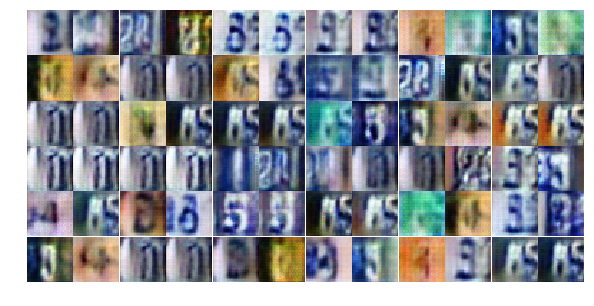

In [51]:
_ = view_samples(-1, samples, 6, 12, figsize=(10,5))

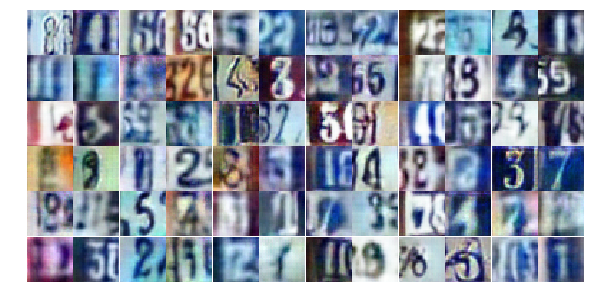

In [19]:
# Standard DCGAN
_ = view_samples(-1, samples, 6, 12, figsize=(10,5))